See the old version for more details

In [1]:
import os
import numpy as np
import pandas as pd

import geopandas as gpd
import ee, eemont
import geemap
import geemap.colormaps as geecm

import matplotlib.pyplot as plt
import cmocean

import xarray as xr
import rioxarray as rxr

In [2]:
from geopandas import GeoSeries as Gs
import folium
import seaborn as sns

In [3]:
from pyce import shape as pyshape
from pyce import raster as pyraster

In [4]:
#from pyce import gee

In [5]:
palette_diff = geecm.get_palette('RdBu', n_class=7)
palette_ndwi = geecm.get_palette('viridis', n_class=7)
palette_gbr = cmocean.cm.ice
palette_dem = cmocean.cm.solar
palette_slope = cmocean.cm.matter
visParams_diff = {'min': -2, 'max': 2, 'palette': palette_diff}
visParams_ndwi = {'min': 0.0, 'max': 0.5, 'palette': palette_ndwi}
visParams_gbr = {'min': 0, 'max': 10, 'palette': palette_gbr}
visParams_dem = {'min': 1000, 'max': 4000, 'palette': palette_dem}
visParams_slope = {'min': 20, 'max': 60, 'palette': palette_slope}

vis_params_landsat = {
    'bands': ['RED', 'GREEN', 'BLUE'],  # RGB
    'min': 0.0,
    'max': 0.3,
    'gamma': 1.3
}

# 3 palettes glacier avec nuances différentes (au choix ici pour exemple)
visGLACIER_1 = {"min": 0, "max": 1, "palette": ["#808080", "#228B22"]}   # Vert forêt
visGLACIER_2 = {"min": 0, "max": 1, "palette": ["#808080", "#FF00FF"]}   # Magenta
visGLACIER_3 = {"min": 0, "max": 1, "palette": ["#808080", "#00FFFF"]}   # Cyan
visGLACIER_4 = {"min": 0, "max": 1, "palette": ["#808080", "#FF0000"]}   # Rouge vif
visWATER_1 = {"min": 0, "max": 1, "palette": ["#00FFFF", "#0000FF", "#00008B"]}  # Cyan → Bleu → Bleu foncé
visWATER_2 = {"min": 0, "max": 1, "palette": ["#00FFFF", "#0000FF", "#00008B"]}
visWATER_3 = {"min": 0, "max": 1, "palette": ["#00FFFF", "#0000FF", "#00008B"]}

visVEGET = {"min": 0, "max": 1, "palette": ["#808080", "#33a02c"]}

# 1. Initialization GEE

In [6]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AVMBsJhxCwgKxgY6bnZ5SdxZ_ZCkBseKTqedJM3I8_Y5d7x0vtMxdc_wdEE



Successfully saved authorization token.


# 2. Load GEE datasets + parameters

In [7]:
dem_glo30 = ee.ImageCollection("COPERNICUS/DEM/GLO30")

In [8]:
scale = 30 #Landsat 30m
projection = "EPSG:4326" #GEE le plus stable avec ce SRC

In [9]:
fc_lia_local = gpd.read_file("C:/Users/ronir/Desktop/Stage_Carrtel_2025/QGIS/Shape LIA/transfer_9869808_files_c7ca226a/Glaciers_1850_final_mourey2025.shp")

In [10]:
fc_lia = ee.FeatureCollection('users/aguerou/ice_and_life/carto_h1b/lia_shp/glaciers_1850_final_mars_2025')

geom_lia_local=fc_lia_local.geometry
geom_lia = fc_lia.geometry()
geom_alpes_FR = ee.FeatureCollection('users/aguerou/ice_and_life/erable_2025/data_ancillary/alpes_francaises')

geom_RGI_2000=ee.FeatureCollection('projects/sat-io/open-datasets/RGI/RGI_VECTOR_MERGED_V7')
geom_RGI_2015=ee.FeatureCollection('users/aguerou/ice_and_life/carto_h1b/lia_shp/c3s_gi_rgi11_s2_2015_v2')

In [11]:
years = range(1984, 2025)
# Créer une liste d'images en important les fichiers du répertoire
Landsat_annualCollection_index= ee.ImageCollection([
    ee.Image(f"projects/ee-roniritzganem/assets/stage_carrtel_2025/landsat_annual_median_index/Landsat_{year}")
    for year in years
])

In [12]:
geom_RGI_FR_2000=ee.FeatureCollection('projects/ee-roniritzganem/assets/stage_carrtel_2025/RGI/RGI_FR_2000')
geom_RGI_FR_2015=ee.FeatureCollection('projects/ee-roniritzganem/assets/stage_carrtel_2025/RGI/RGI_FR_2015')


In [13]:
geom_RGI_FR_2000_propre=ee.FeatureCollection('projects/ee-roniritzganem/assets/stage_carrtel_2025/RGI/RGI_FR_Strict_2000')
geom_RGI_FR_2015_propre=ee.FeatureCollection('projects/ee-roniritzganem/assets/stage_carrtel_2025/RGI/RGI_FR_Strict_2015')

In [14]:
lake_shape=gpd.read_file('C:/Users/ronir/Desktop/Stage_Carrtel_2025/Inventaire_Lac_alpin/Inventaire_lacs_2022/Inventaire_lacs_2022/inventaire_tous_lacs_2022.shp')  
lake_shape = lake_shape.to_crs(fc_lia_local.crs)

In [15]:
lake_shape_clipped=gpd.read_file('C:/Users/ronir/Desktop/Google_Earth_Engine/Export/Vectorisation_V1/Shapefile/lake_shape_clipped.shp')

In [16]:
lake_classif_inrae_clean_gt900m2 = gpd.read_file("C:/Users/ronir/Desktop/Stage_Carrtel_2025/Resultats/validation_lake_classif/lake_classif_inrae_clean_gt900m2/lake_classif_inrae_clean_gt900m2.dbf")

In [17]:
# dem = ee.ImageCollection(dem_glo30).filterBounds(fc_lia).select("DEM")
# dem_mosaic = dem.mosaic().clip(fc_lia)
# slope = dem.map(get_slope).mosaic().clip(fc_lia) /
# #need to map on single image for slope function to work fine
# SlopeThresh = 30 
# AltitudeThresh = 1000
# slope_mask = slope.lt(SlopeThresh)
# valley_mask = dem_mosaic.gt(AltitudeThresh)

----------------------------

#  Validation Classification INRAE 2022

In [18]:
lake_shape_clipped = lake_shape_clipped.to_crs(fc_lia_local.crs)

In [19]:
lake_shape_clipped = lake_shape_clipped.clip(fc_lia_local)

checking duplicates

In [20]:
import geopandas as gpd
import pandas as pd

# On réinitialise l'index si besoin
lake_shape_clipped = lake_shape_clipped.reset_index(drop=True)

# Cherche les doublons géométriques
duplicates_mask = lake_shape_clipped.duplicated(subset='id', keep=False)

# Filtrer uniquement les doublons
duplicates = lake_shape_clipped[duplicates_mask]

# Afficher les IDs correspondants
print("IDs des géométries dupliquées :")
print(duplicates["id"].tolist())

IDs des géométries dupliquées :
[22, 22, 37, 37, 189, 189, 85, 85, 85, 85]


In [21]:
import geopandas as gpd
import pandas as pd

# On réinitialise l'index si besoin
lake_shape_clipped = lake_classif_inrae_clean_gt900m2.reset_index(drop=True)

# Cherche les doublons géométriques
duplicates_mask = lake_shape_clipped.duplicated(subset='id', keep=False)

# Filtrer uniquement les doublons
duplicates = lake_shape_clipped[duplicates_mask]

# Afficher les IDs correspondants
print("IDs des géométries dupliquées :")
print(duplicates["id"].tolist())

IDs des géométries dupliquées :
[]


drop duplicates

In [22]:
lake_inrae_clean = lake_shape_clipped.drop_duplicates(subset="geometry", keep="first")

difference of surface between classif before and after dropping

In [23]:
lake_shape_clipped.area.sum()*1e-6

np.float64(2.3621114693413934)

In [24]:
lake_inrae_clean.area.sum()*1e-6

np.float64(2.3621114693413934)

In [25]:
difference_after_cleaning = lake_shape_clipped.area.sum()*1e-6 - lake_inrae_clean.area.sum()*1e-6

In [26]:
difference_after_cleaning*1e6

np.float64(0.0)

Filtering < 900m² lakes

In [27]:
lake_inrae_clean["area_m2"] = lake_inrae_clean.geometry.area
lake_inrae_clean_filtered = lake_inrae_clean[lake_inrae_clean["area_m2"] >= 900]

In [28]:
len(lake_inrae_clean_filtered)

200

In [29]:
lake_inrae_clean_filtered.area.sum()*1e-6

np.float64(2.3621114693413934)

In [30]:
difference_after_filtering_900m2 = lake_inrae_clean.area.sum()*1e-6 - lake_inrae_clean_filtered.area.sum()*1e-6

In [31]:
difference_after_filtering_900m2*1e6

np.float64(0.0)

In [32]:
len(lake_inrae_clean[lake_inrae_clean["area_m2"] < 900])

0

In [33]:
area_small_lakes = lake_inrae_clean[lake_inrae_clean["area_m2"] < 900].geometry.area.sum()

In [34]:
area_small_lakes

np.float64(0.0)

In [35]:
df_cleaning_inrae_classif = gpd.GeoDataFrame([{
    "initial_area_km2": lake_shape_clipped.area.sum()*1e-6,
    "area_after_duplicates_cleaning_km2": lake_inrae_clean.area.sum()*1e-6,
    "difference_after_cleaning_m2": difference_after_cleaning*1e6,
    "area_after_filtering_900m_km2": lake_inrae_clean_filtered.area.sum()*1e-6,
    "diffrence_between_clean_and_filter_m2": difference_after_filtering_900m2*1e6,
    "initial_number_of_lake_in_LIA": len(lake_inrae_clean),
    "number_of_lake_over_900m2_in_LIA": len(lake_inrae_clean_filtered),
    "number_of_lake_under_900m2_in_LIA_": len(lake_inrae_clean[lake_inrae_clean["area_m2"] < 900]),
    "area_of_lake_under_900m2_in_LIA_in_m2": area_small_lakes,
    "percent_of_lake_under_900m2_number": len(lake_inrae_clean[lake_inrae_clean["area_m2"] < 900])/len(lake_inrae_clean),
    "percent_of_lake_under_900m2_area": area_small_lakes/lake_inrae_clean.area.sum()*100
}])

In [36]:
df_cleaning_inrae_classif = df_cleaning_inrae_classif.T

In [37]:
df_cleaning_inrae_classif

,0
initial_area_km2,2.362111
area_after_duplicates_cleaning_km2,2.362111
difference_after_cleaning_m2,0.000000
area_after_filtering_900m_km2,2.362111
diffrence_between_clean_and_filter_m2,0.000000
initial_number_of_lake_in_LIA,200.000000
number_of_lake_over_900m2_in_LIA,200.000000
number_of_lake_under_900m2_in_LIA_,0.000000
area_of_lake_under_900m2_in_LIA_in_m2,0.000000
percent_of_lake_under_900m2_number,0.000000


Check that everything is in LIA

In [38]:
lake_inrae_to_compare = lake_inrae_clean_filtered[['id','geometry', 'area_m2']]

In [39]:
joined = lake_inrae_to_compare.sjoin(fc_lia_local, how='inner', predicate='intersects')

In [40]:
lake_in_lia = lake_inrae_to_compare.loc[lake_inrae_to_compare.index.isin(joined.index)]
lake_not_in_lia = lake_inrae_to_compare.loc[~lake_inrae_to_compare.index.isin(joined.index)]

In [41]:
len(lake_in_lia), len(lake_not_in_lia)

(200, 0)

In [42]:
lake_inrae_to_compare[lake_inrae_to_compare['id']==85]

,id,geometry,area_m2
178,85,"POLYGON ((1015611.451 6495990.812, 1015615.628...",5466.015905


In [43]:
len(lake_inrae_to_compare['id'].unique())

200

there is 2 different lakes larger than 900m2 with the samed id : 85

In [44]:
mask_85 = lake_inrae_clean_filtered["id"] == 85
duplicates_85 = lake_inrae_clean_filtered[mask_85]


In [45]:
# 2. Trouver les lignes avec id == 85
mask_85 = lake_inrae_clean_filtered["id"] == 85
duplicates_85 = lake_inrae_clean_filtered[mask_85]

# 3. Garder la première ligne intacte, modifier les autres
if len(duplicates_85) > 1:
    # Récupérer l'ID max existant
    max_id = lake_inrae_clean_filtered["id"].max()
    
    # Nouveaux IDs pour les doublons (sauf le premier)
    new_ids = list(range(max_id + 1, max_id + len(duplicates_85)))
    
    # Index des doublons à modifier (sauf le premier)
    idx_to_change = duplicates_85.index[1:]
    
    # Mise à jour des IDs
    lake_inrae_clean_filtered.loc[idx_to_change, "id"] = new_ids

# ✅ Vérification
print(lake_inrae_clean_filtered[lake_inrae_clean_filtered["id"].isin([85] + new_ids)])

NameError: name 'new_ids' is not defined

In [46]:
lake_inrae_clean_filtered[lake_inrae_clean_filtered["id"].isin([85])]

,id,Remarques,Evolution,Date,Surface,Categorie,Barrage,NAME,ID_2_2,INSEE,NOM,ID_1,ID_3,area_m2,geometry
178,85,GL,V,2022,5475,P,None,Rhemes-Golette,85.0,73296,Tignes,85.0,NaN,5466.015905,"POLYGON ((1015611.451 6495990.812, 1015615.628..."


In [47]:
len(lake_inrae_clean_filtered)

200

In [48]:
len(lake_inrae_clean_filtered['id'].unique())

200

exporting cleaned classification

In [49]:
# lake_inrae_clean_filtered.to_file('C:/Users/ronir/Desktop/Stage_Carrtel_2025/Resultats/validation_lake_classif/lake_classif_inrae_clean_gt900m2')

# Metrics

We need : Number of lakes, Total Area, Repartition of lake vs size

In [50]:
total_area_2022 = lake_inrae_clean_filtered['area_m2'].sum()/1e6

Comparaison with own classification

In [51]:
lake_classif = gpd.read_file("C:/Users/ronir/Desktop/Google_Earth_Engine/Vdef/Lake/lake_def_clean_with_id.shp")

In [52]:
lake_classif_to_validate = lake_classif[lake_classif['year'] == 2022]

In [53]:
lake_classif_to_validate = lake_classif_to_validate.to_crs(fc_lia_local.crs)

correcting the 431 to 365 mismatch (for validation visu, need to fix that after (22/06/2025)

In [54]:
lake_classif_to_validate.loc[lake_classif_to_validate['lake_id'] == 431, 'lake_id'] = 365

checking duplicates

In [55]:
# On réinitialise l'index si besoin
lake_classif_to_validate = lake_classif_to_validate.reset_index(drop=True)

# Cherche les doublons géométriques
duplicates_mask = lake_classif_to_validate.duplicated(subset='geometry', keep=False)

In [56]:
duplicates = lake_classif_to_validate[duplicates_mask]

In [57]:
duplicates

,year,source,value,lake_id,Time,geometry


no duplicates

In [58]:
lake_classif_to_validate['area_m2'] = lake_classif_to_validate.geometry.area

In [59]:
len(lake_classif_to_validate['lake_id'].unique())

78

Which lake is detected, which one is not

In [60]:
joined_final = lake_inrae_clean_filtered.sjoin(lake_classif_to_validate, how='inner', predicate='intersects')

lake_detected_2022_inrae = lake_inrae_clean_filtered.loc[lake_inrae_clean_filtered.index.isin(joined_final.index)]
lake_not_detected_2022_inrae = lake_inrae_clean_filtered.loc[~lake_inrae_clean_filtered.index.isin(joined_final.index)]

In [61]:
len(lake_not_detected_2022_inrae)

121

In [62]:
len(lake_detected_2022_inrae['id'].unique())

79

In [63]:
joined_test = lake_classif_to_validate.sjoin(lake_detected_2022_inrae, how='inner', predicate = 'intersects')

In [64]:
test = lake_classif_to_validate.loc[~lake_classif_to_validate.index.isin(joined_test.index)]

In [65]:
test

,year,source,value,lake_id,Time,geometry,area_m2


lake 9 and 70 are artefacts in 2022, 9 is an artifact in 2000, example for the artifacts in the 40 years

## Results in gdf

In [66]:
df_results = gpd.GeoDataFrame([{
    "area_of_lakes_2022_inrae": total_area_2022
}])

In [67]:
df_results

,area_of_lakes_2022_inrae
0,2.362111


In [68]:
df_results['number_of_lakes_2022_inrea'] = len(lake_inrae_clean_filtered['id'].unique())

In [69]:
df_results['number_of_detected_lake_inrae'] =  len(lake_detected_2022_inrae)

In [70]:
df_results['number_of_not_detected_lake_inrae'] =  len(lake_not_detected_2022_inrae)

In [71]:
df_results['number_of_detected_lakes_2022'] = len(lake_classif_to_validate['lake_id'].unique())

In [72]:
df_results['number_of_artifacts_lakes_2022'] = len(test)

In [73]:
df_results['area_of_detected_lakes_2022'] =  lake_classif_to_validate.geometry.area.sum()*1e-6

In [74]:
df_results['detected_surface_ratio'] =  df_results['area_of_detected_lakes_2022']/df_results['area_of_lakes_2022_inrae'] *100 

In [75]:
df_results.T

,0
area_of_lakes_2022_inrae,2.362111
number_of_lakes_2022_inrea,200.000000
number_of_detected_lake_inrae,79.000000
number_of_not_detected_lake_inrae,121.000000
number_of_detected_lakes_2022,78.000000
number_of_artifacts_lakes_2022,0.000000
area_of_detected_lakes_2022,1.364509
detected_surface_ratio,57.766482


In [76]:
df_results.T

,0
area_of_lakes_2022_inrae,2.362111
number_of_lakes_2022_inrea,200.000000
number_of_detected_lake_inrae,79.000000
number_of_not_detected_lake_inrae,121.000000
number_of_detected_lakes_2022,78.000000
number_of_artifacts_lakes_2022,0.000000
area_of_detected_lakes_2022,1.364509
detected_surface_ratio,57.766482


# Visu

Nombre de lacs : 200
Aire totale (km²) : 2.3621
Taille moyenne (km²) : 0.0118
Médiane (km²) : 0.0034
1er quartile (km²) : 0.0019
3e quartile (km²) : 0.0086


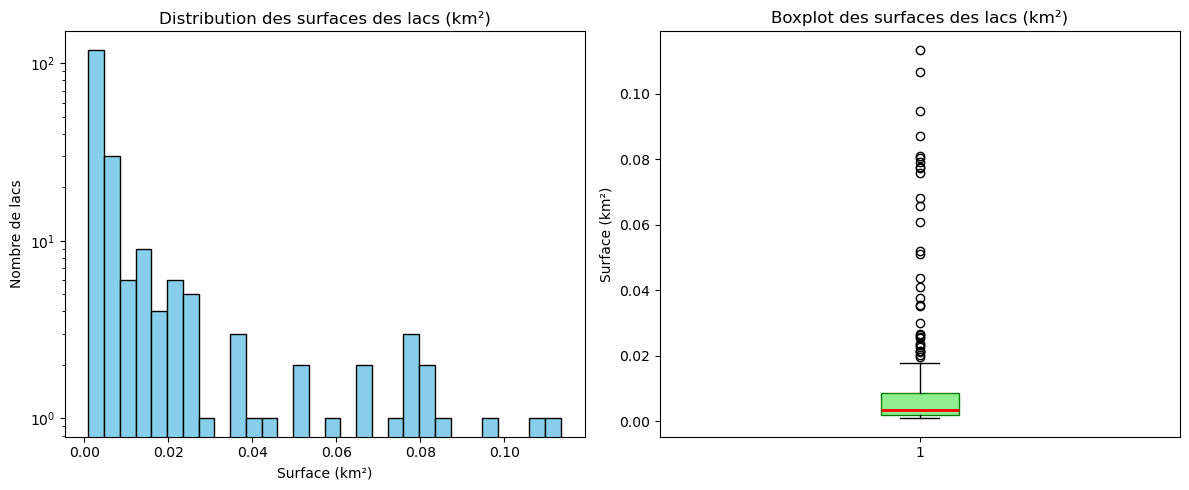

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# Calcul des surfaces individuelles en km²
lake_areas_km2 = lake_inrae_clean_filtered.geometry.area * 1e-6

# Statistiques descriptives
total_area_km2 = lake_areas_km2.sum()
number_of_lakes = len(lake_inrae_clean_filtered['id'].unique())
mean_area_km2 = lake_areas_km2.mean()
median_area_km2 = lake_areas_km2.median()
quartiles = lake_areas_km2.quantile([0.25, 0.5, 0.75])

# Affichage des statistiques
print(f"Nombre de lacs : {number_of_lakes}")
print(f"Aire totale (km²) : {total_area_km2:.4f}")
print(f"Taille moyenne (km²) : {mean_area_km2:.4f}")
print(f"Médiane (km²) : {median_area_km2:.4f}")
print(f"1er quartile (km²) : {quartiles[0.25]:.4f}")
print(f"3e quartile (km²) : {quartiles[0.75]:.4f}")

# Visualisation

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Histogramme des tailles des lacs
ax[0].hist(lake_areas_km2, bins=30, color='skyblue', edgecolor='black')
ax[0].set_title("Distribution des surfaces des lacs (km²)")
ax[0].set_xlabel("Surface (km²)")
ax[0].set_ylabel("Nombre de lacs")
ax[0].set_yscale('log')  # optionnel : échelle logarithmique si très dispersé

# Boîte à moustaches (boxplot)
ax[1].boxplot(lake_areas_km2, vert=True, patch_artist=True,
              boxprops=dict(facecolor='lightgreen', color='green'),
              medianprops=dict(color='red', linewidth=2))
ax[1].set_title("Boxplot des surfaces des lacs (km²)")
ax[1].set_ylabel("Surface (km²)")

plt.tight_layout()
plt.show()


=== Computed Classification ===
Total area (km²): 1.3645
Mean area (km²): 0.0150
Median area (km²): 0.0041
1st quartile (km²): 0.0011
3rd quartile (km²): 0.0155

=== Reference Classification (INRAE 2022) ===
Total area (km²): 2.3621
Mean area (km²): 0.0118
Median area (km²): 0.0034
1st quartile (km²): 0.0019
3rd quartile (km²): 0.0086


C:\Users\ronir\AppData\Local\Temp\ipykernel_29432\3693729798.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax[1].boxplot([areas_reference, areas_classif], vert=True, patch_artist=True,


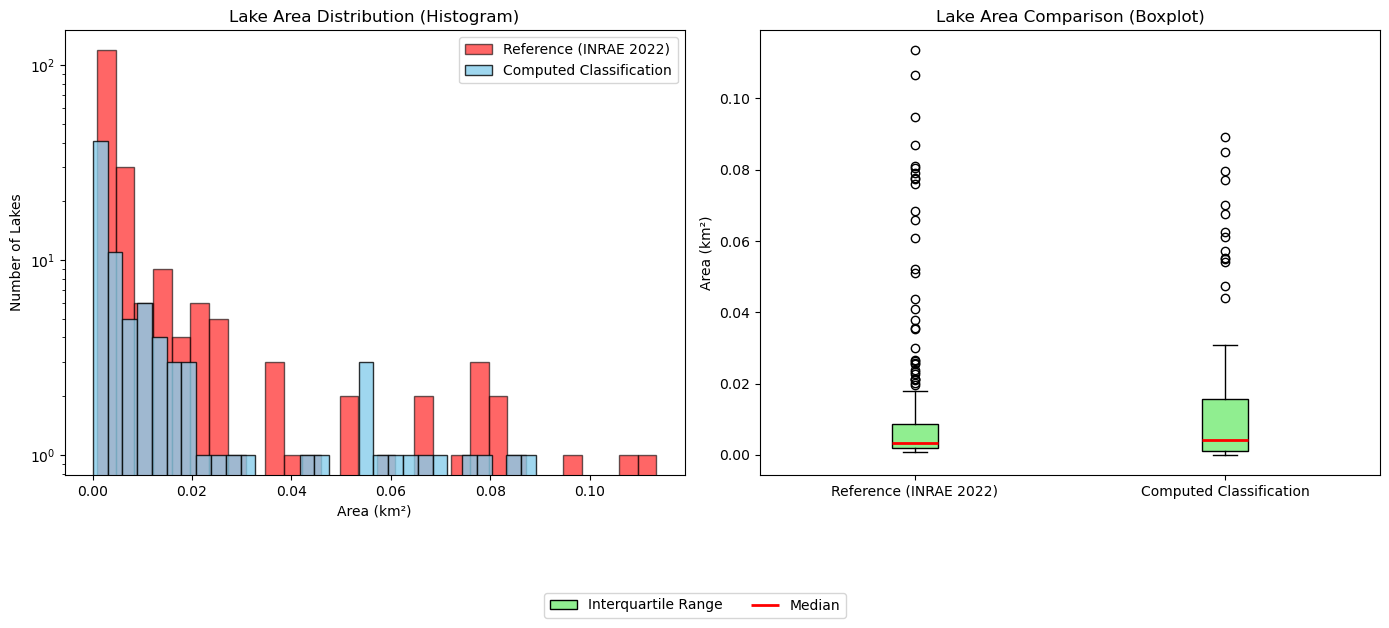

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# --- Compute lake areas (km²) for both datasets ---
areas_classif = lake_classif_to_validate.geometry.area * 1e-6 
areas_reference = lake_inrae_clean_filtered.geometry.area * 1e-6

# --- Descriptive statistics ---
def describe(areas, label):
    total = areas.sum()
    mean = areas.mean()
    median = areas.median()
    q1 = areas.quantile(0.25)
    q3 = areas.quantile(0.75)
    
    print(f"\n=== {label} ===")
    print(f"Total area (km²): {total:.4f}")
    print(f"Mean area (km²): {mean:.4f}")
    print(f"Median area (km²): {median:.4f}")
    print(f"1st quartile (km²): {q1:.4f}")
    print(f"3rd quartile (km²): {q3:.4f}")
    return total, mean, median, q1, q3

# Show stats
describe(areas_classif, "Computed Classification")
describe(areas_reference, "Reference Classification (INRAE 2022)")

# --- Visualization ---
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Histogram comparison
ax[0].hist(areas_reference, bins=30, alpha=0.6, label="Reference (INRAE 2022)", color='red', edgecolor='black')
ax[0].hist(areas_classif, bins=30, alpha=0.8, label="Computed Classification", color='skyblue', edgecolor='black')
ax[0].set_title("Lake Area Distribution (Histogram)")
ax[0].set_xlabel("Area (km²)")
ax[0].set_ylabel("Number of Lakes")
ax[0].legend()
ax[0].set_yscale('log')

# Boxplot comparison
box = ax[1].boxplot([areas_reference, areas_classif], vert=True, patch_artist=True,
                    labels=["Reference (INRAE 2022)", "Computed Classification"],
                    boxprops=dict(facecolor='lightgreen', color='black'),
                    medianprops=dict(color='red', linewidth=2))

ax[1].set_title("Lake Area Comparison (Boxplot)")
ax[1].set_ylabel("Area (km²)")

# Add legend manually under the boxplot
fig.legend([box["boxes"][0], box["medians"][0]],
           ['Interquartile Range', 'Median'],
           loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()


C:\Users\ronir\anaconda3\envs\gee\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\ronir\anaconda3\envs\gee\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


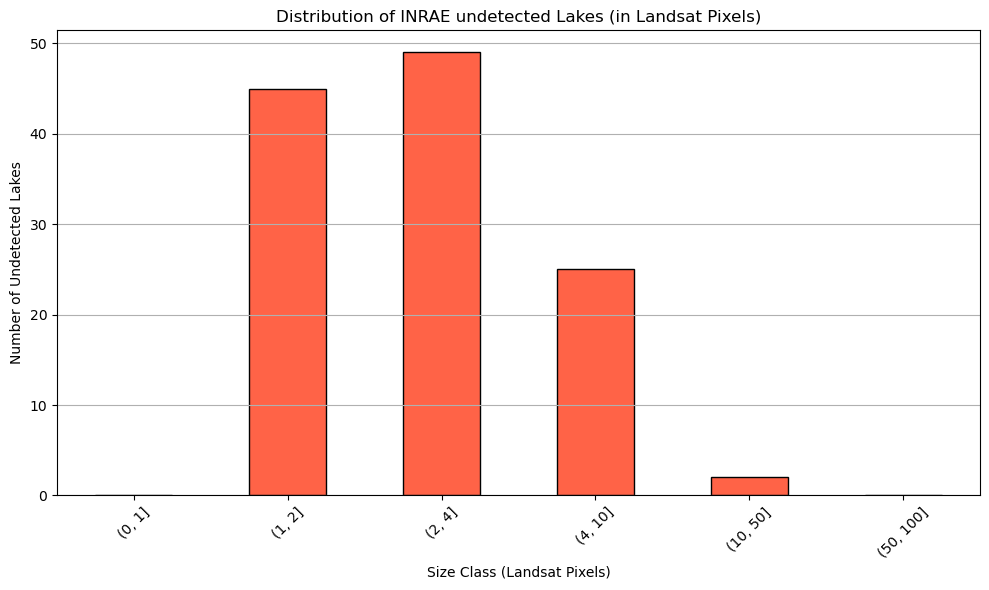

In [79]:
# Calculate surface area in Landsat pixels
lake_not_detected_2022_inrae['landsat_pixels'] = lake_not_detected_2022_inrae.geometry.area / 900

# Define bins by number of pixels (as requested)
bins = [0, 1, 2, 4, 10, 50, 100]
labels = ['<1', '1–2', '2–4', '4–10', '10–50', '50–100', '100–500', '500–1k', '>1k']
lake_not_detected_2022_inrae['pixel_bin'] = pd.cut(lake_not_detected_2022_inrae['landsat_pixels'], bins=bins)

lake_not_detected_2022_inrae
# Plot histogram
plt.figure(figsize=(10, 6))
lake_not_detected_2022_inrae['pixel_bin'].value_counts().sort_index().plot(kind='bar', color='tomato', edgecolor='black')
plt.title("Distribution of INRAE undetected Lakes (in Landsat Pixels)")
plt.xlabel("Size Class (Landsat Pixels)")
plt.ylabel("Number of Undetected Lakes")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


C:\Users\ronir\anaconda3\envs\gee\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\ronir\anaconda3\envs\gee\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\ronir\anaconda3\envs\gee\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

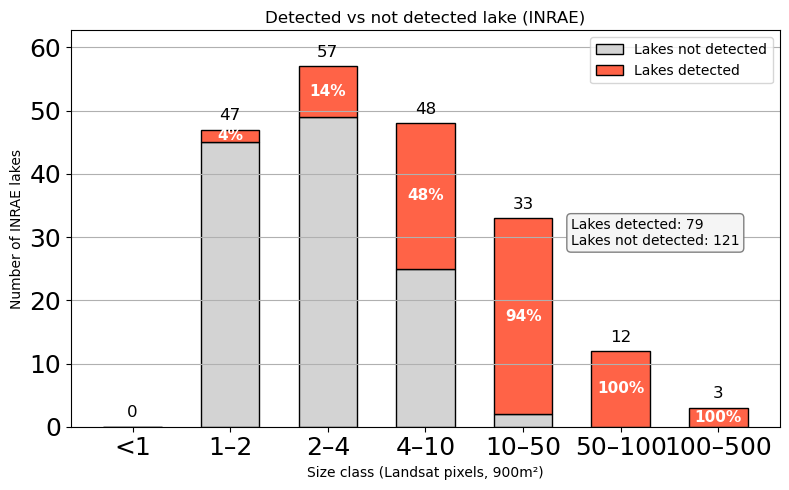

In [140]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Define full bins and labels
bins = [0, 1, 2, 4, 10, 50, 100, 500, 1000, float('inf')]
labels = ['<1', '1–2', '2–4', '4–10', '10–50', '50–100', '100–500', '500–1k', '>1k']

# 2. Add pixels + classes to the 3 datasets
for df in [lake_detected_2022_inrae, lake_not_detected_2022_inrae, lake_inrae_clean_filtered]:
    df['landsat_pixels'] = df.geometry.area / 900
    df['pixel_bin'] = pd.cut(df['landsat_pixels'], bins=bins, labels=labels, right=False)

# 3. Limit to classes
filtered_labels = ['<1', '1–2', '2–4', '4–10', '10–50', '50–100', '100–500']

detected_counts = lake_detected_2022_inrae['pixel_bin'].value_counts().sort_index().loc[filtered_labels]
not_detected_counts = lake_not_detected_2022_inrae['pixel_bin'].value_counts().sort_index().loc[filtered_labels]
total_counts = detected_counts.add(not_detected_counts, fill_value=0).astype(int)

# 4. Global sums
total_detected = int(detected_counts.sum())
total_not_detected = int(not_detected_counts.sum())

# 5. Plot bars
x = range(len(filtered_labels))
bar_width = 0.6

plt.figure(figsize=(8, 5))

plt.bar(x, not_detected_counts, width=bar_width, label='Lakes not detected', color='lightgray', edgecolor='black')
plt.bar(x, detected_counts, width=bar_width, bottom=not_detected_counts, label='Lakes detected', color='tomato', edgecolor='black')

# 6. Add % and total on each bar
for i, label in enumerate(filtered_labels):
    total = total_counts[label]
    detected = detected_counts.get(label, 0)
    if total > 0:
        percent = round(100 * detected / total)
        plt.text(i, not_detected_counts.get(label, 0) + detected / 2,
                 f"{percent}%", ha='center', va='center', fontsize=11, color='white', fontweight='bold')
    plt.text(i, total + 1, str(total), ha='center', va='bottom', fontsize=12)

# 7. Add box under legend
textstr = f'Lakes detected: {total_detected}\nLakes not detected: {total_not_detected}'
props = dict(boxstyle='round', facecolor='whitesmoke', edgecolor='gray')
plt.gcf().text(0.72, 0.5, textstr, fontsize=10, bbox=props)

# 8. Layout

plt.tick_params(axis='y', labelsize=18)
plt.tick_params(axis='x', labelsize=18)

plt.xticks(x, filtered_labels, rotation=0)
plt.xlabel("Size class (Landsat pixels, 900m²)")
plt.ylabel("Number of INRAE lakes")
plt.title("Detected vs not detected lake (INRAE)")
plt.ylim(0, total_counts.max() * 1.1)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('C:/Users/ronir/Desktop/Stage_Carrtel_2025/Figure_def/INRAE_vs_classif_number')


plt.show()

In [176]:
df_surface_ratio.sort_values(by='area_inrae')

,lake_id,area_detected_lake_m²,area_inrae,surface_covered_ratio,real_surface_covered_ratio_clipped,landsat_pixels,pixel_bin,area_m2_classif,area_m2_inrae,surface_diff_m2,area_pixels_landsat,surface_diff_percent
76,2253.0,540.133464,1128.012572,47.883639,47.883639,1.253347,1–2,540.133464,1128.012572,-587.879109,1.253347,-52.116361
74,1611.0,156.776521,1938.237046,8.088614,8.088614,2.153597,2–4,156.776521,1938.237046,-1781.460524,2.153597,-91.911386
43,248.0,1105.410797,2103.159011,52.559545,52.559545,2.336843,2–4,1105.410797,2103.159011,-997.748214,2.336843,-47.440455
72,1249.0,959.499164,2544.469115,37.709208,37.709208,2.827188,2–4,959.499164,2544.469115,-1584.969952,2.827188,-62.290792
55,330.0,828.968582,2959.452475,28.010877,28.010877,3.288281,2–4,828.968582,2959.452475,-2130.483893,3.288281,-71.989123
...,...,...,...,...,...,...,...,...,...,...,...,...
33,207.0,77015.763522,81027.918376,95.048429,95.048429,90.031020,50–100,77015.763522,81027.918376,-4012.154854,90.031020,-4.951571
36,221.0,79630.957788,87077.219631,91.448668,91.448668,96.752466,50–100,79630.957788,87077.219631,-7446.261843,96.752466,-8.551332
65,367.0,84995.268306,94886.780436,89.575458,89.575457,105.429756,100–500,84995.268306,94886.780436,-9891.512130,105.429756,-10.424542
41,245.0,54934.157780,106622.284269,51.522211,51.522211,118.469205,100–500,54934.157780,106622.284269,-51688.126489,118.469205,-48.477789


In [179]:
grouped

,pixel_bin,sum_area_inrae,sum_area_detected,weighted_avg_surface_covered_ratio
0,1–2,0.001128,0.000540,47.883639
1,2–4,0.022709,0.006866,30.235935
2,4–10,0.135632,0.046957,34.620776
3,10–50,0.674240,0.372487,55.245387
4,50–100,0.856604,0.708503,82.710649
5,100–500,0.314983,0.229156,72.751988


C:\Users\ronir\AppData\Local\Temp\ipykernel_29432\2279320959.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_surface_ratio.groupby('pixel_bin', observed=True).apply(compute_group_stats).reset_index()
C:\Users\ronir\anaconda3\envs\gee\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\ronir\anaconda3\envs\gee\Lib\site-packages\geopandas\geodataframe.py:181

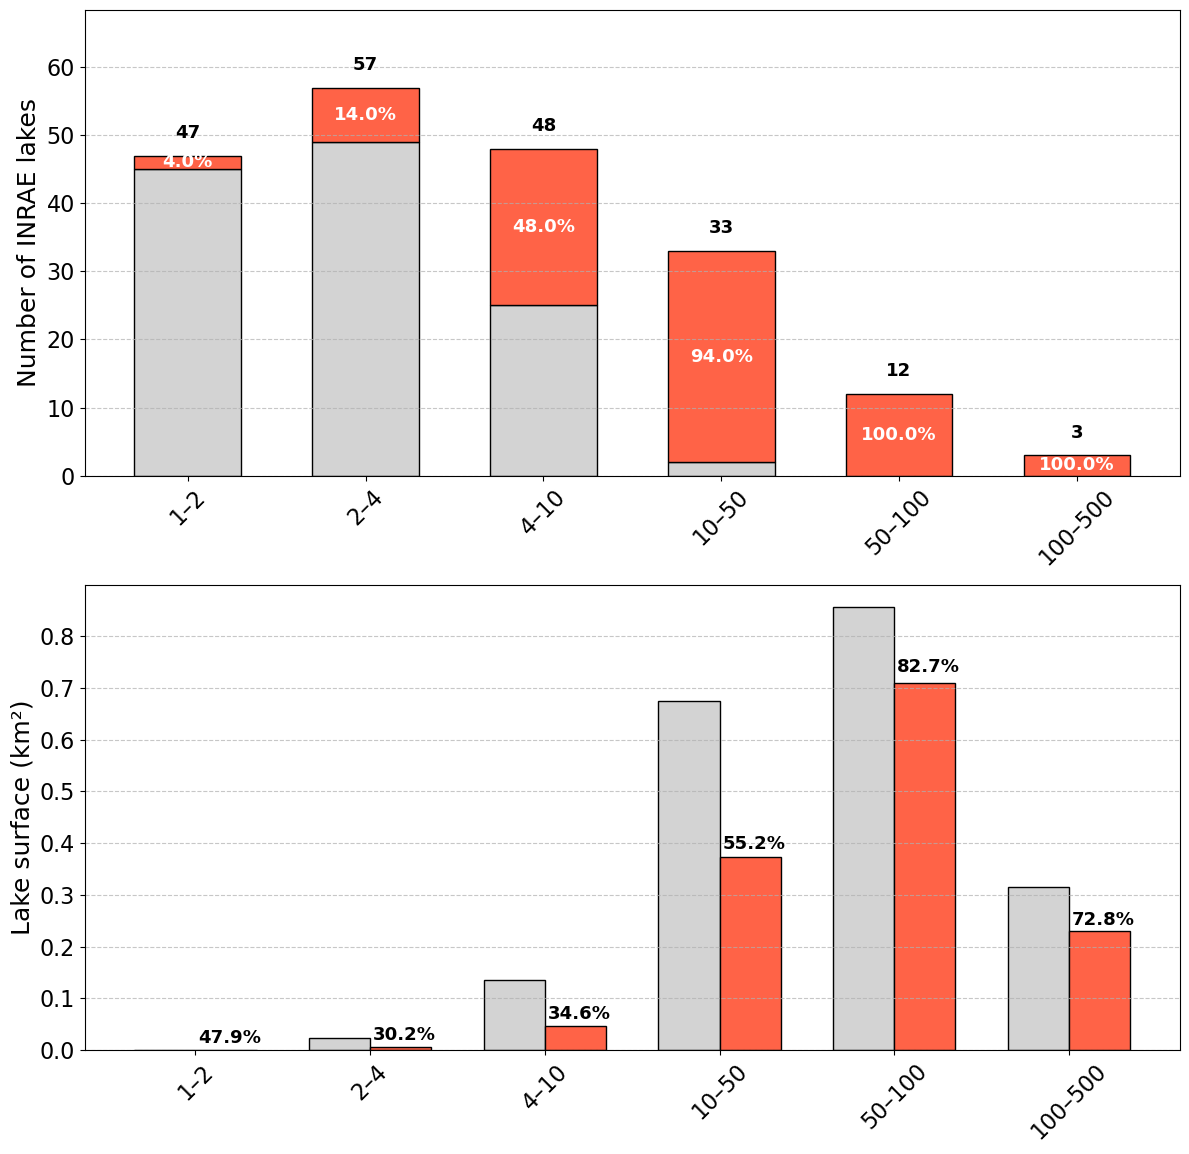

Moyenne pondérée globale de surface couverte : 68.0 %

--- Résumé global affiché ---
Total INRAE surface: 2.01 km² | Total detected surface: 1.36 km² | Avg detected ratio: 68.0 %
Lakes detected: 79 | Lakes not detected: 121
pixel_bin
1–2         2
2–4         8
4–10       23
10–50      31
50–100     12
100–500     3
Name: count, dtype: int64


In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === PRÉPARATION DES DONNÉES POUR LE GRAPHE SURFACES ===
df_surface_ratio['surface_covered_ratio'] = (
    df_surface_ratio['area_detected_lake_m²'] / df_surface_ratio['area_inrae']
) * 100

def compute_group_stats(x):
    sum_area_inrae = x['area_inrae'].sum()
    weighted_ratio = (
        (x['surface_covered_ratio'] * x['area_inrae']).sum() / sum_area_inrae
        if sum_area_inrae > 0 else np.nan
    )
    return pd.Series({
        'sum_area_inrae': sum_area_inrae,
        'sum_area_detected': x['area_detected_lake_m²'].sum(),
        'weighted_avg_surface_covered_ratio': weighted_ratio
    })

grouped = df_surface_ratio.groupby('pixel_bin', observed=True).apply(compute_group_stats).reset_index()

# On retire la classe <1 pour le graphe de surface
grouped = grouped[grouped['pixel_bin'] != '<1']

# Conversion en km²
grouped['sum_area_inrae'] /= 1e6
grouped['sum_area_detected'] /= 1e6
total_inrae = grouped['sum_area_inrae'].sum()
total_detected_surface = grouped['sum_area_detected'].sum()
global_ratio = (total_detected_surface / total_inrae) * 100

# === PRÉPARATION DES DONNÉES POUR LE GRAPHE DE COMPTAGE ===
bins = [0, 1, 2, 4, 10, 50, 100, 500, 1000, float('inf')]
labels = ['<1', '1–2', '2–4', '4–10', '10–50', '50–100', '100–500', '500–1k', '>1k']

for df in [lake_detected_2022_inrae, lake_not_detected_2022_inrae, lake_inrae_clean_filtered]:
    df['landsat_pixels'] = df.geometry.area / 900
    df['pixel_bin'] = pd.cut(df['landsat_pixels'], bins=bins, labels=labels, right=False)

# On retire la classe <1 ici aussi
filtered_labels = ['1–2', '2–4', '4–10', '10–50', '50–100', '100–500']

detected_counts = lake_detected_2022_inrae['pixel_bin'].value_counts().sort_index().loc[filtered_labels]
not_detected_counts = lake_not_detected_2022_inrae['pixel_bin'].value_counts().sort_index().loc[filtered_labels]
total_counts = detected_counts.add(not_detected_counts, fill_value=0).astype(int)
total_detected = int(detected_counts.sum())
total_not_detected = int(not_detected_counts.sum())

# === PLOT COMBINÉ AVEC ORDRE INVERSÉ ===
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=False)

# === GRAPHE 1 (EN HAUT) : NOMBRE DE LACS ===
ax1 = axes[0]
x1 = np.arange(len(filtered_labels))
bar_width = 0.6

ax1.bar(x1, not_detected_counts, width=bar_width, color='lightgray', edgecolor='black')
ax1.bar(x1, detected_counts, width=bar_width, bottom=not_detected_counts, color='tomato', edgecolor='black')

for i, label in enumerate(filtered_labels):
    total = total_counts[label]
    detected = detected_counts.get(label, 0)
    if total > 0:
        percent = round(100 * detected / total)
        ax1.text(i, not_detected_counts.get(label, 0) + detected / 2,
                 f"{percent:.1f}%", ha='center', va='center', fontsize=13, color='white', fontweight='bold')
    ax1.text(i, total + 2, str(total), ha='center', va='bottom', fontsize=13,  fontweight='bold')

ax1.set_xticks(x2)
ax1.set_xticklabels(filtered_labels, rotation=45, fontsize=16)
ax1.set_ylabel("Number of INRAE lakes", fontsize=18)
#ax1.set_title("Detected vs Not Detected Lakes (INRAE)", fontsize=20, fontweight='bold')
ax1.tick_params(axis='y', labelsize=16)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_ylim(0, total_counts.max() * 1.2)

# === GRAPHE 2 (EN BAS) : SURFACE ===
ax2 = axes[1]
x2 = np.arange(len(grouped))
width = 0.35

ax2.bar(x2 - width/2, grouped['sum_area_inrae'], width=width, color='lightgray', edgecolor='black')
ax2.bar(x2 + width/2, grouped['sum_area_detected'], width=width, color='tomato', edgecolor='black')

ax2.set_ylabel('Lake surface (km²)', fontsize=18)
#ax2.set_title('INRAE vs Detected Surface per Size Class', fontsize=20, fontweight='bold')
ax2.set_xticks(x2)
ax2.set_xticklabels(grouped['pixel_bin'], rotation=45, fontsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

for i, (x_pos, det, pct) in enumerate(zip(x2, grouped['sum_area_detected'], grouped['weighted_avg_surface_covered_ratio'])):
    if pd.notna(pct) and np.isfinite(pct):
        y_pos = det + max(det * 0.02, 0.005)
        ax2.text(x_pos + width/2 + 0.02, y_pos, f'{pct:.1f}%', ha='center', va='bottom', fontsize=13, fontweight='bold')
# Afficher le nombre de lacs détectés au-dessus des barres rouges du bas
# for i, x_pos in enumerate(x2):
#     bin_label = grouped['pixel_bin'].iloc[i]
#     lake_count = detected_counts.get(bin_label, 0)
#     det = grouped['sum_area_detected'].iloc[i]
#     ax2.text(x_pos + width/2, det +0.09 + max(det * 0.07, 0.01),
#              f"{lake_count}", ha='center', va='bottom',
#              fontsize=13, fontweight='bold', color='black')
# # === INFOS ENCADRÉES ===
# info_lakes = f'Lakes detected: {total_detected}\nLakes not detected: {total_not_detected}'
# fig.text(0.72, 0.74, info_lakes, fontsize=12, bbox=dict(boxstyle='round', facecolor='whitesmoke', edgecolor='gray'))

# info_surface = (
#     f"Total INRAE surface: {total_inrae:.2f} km²\n"
#     f"Total detected surface: {total_detected_surface:.2f} km²\n"
#     f"Avg detected ratio: {global_ratio:.1f} %"
# )
# fig.text(0.02, 0.03, info_surface, fontsize=12, bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray'))

# === AFFICHAGE + EXPORT ===
plt.tight_layout(rect=[0, 0, 1, 0.97])
#plt.savefig('C:/Users/ronir/Desktop/Stage_Carrtel_2025/Figure_def/INRAE_surface_and_number_v3.png', dpi=300)
plt.show()

weighted_global_ratio = (
    (df_surface_ratio['surface_covered_ratio'] * df_surface_ratio['area_inrae']).sum() /
    df_surface_ratio['area_inrae'].sum()
)
print(f"Moyenne pondérée globale de surface couverte : {weighted_global_ratio:.1f} %")

# === PRINT DES INFOS RÉELLEMENT AFFICHÉES ===
print("\n--- Résumé global affiché ---")
print(info_surface.replace('\n', ' | '))
print(info_lakes.replace('\n', ' | '))
print(detected_counts)

## Calculating Surface in and out of classification


dissolving by lake id

In [81]:
lake_classif_to_validate_diss = lake_classif_to_validate.dissolve(by='lake_id')

recalculating area

In [82]:
lake_classif_to_validate_diss['area_diss_lake_m²'] = lake_classif_to_validate_diss.geometry.area

In [83]:
lake_classif_to_validate_diss = lake_classif_to_validate_diss.drop(columns='area_m2')

In [84]:
surface_in_inrae = lake_classif_to_validate_diss[['geometry']].clip(lake_detected_2022_inrae)

In [85]:
surface_not_in_inrae = lake_classif_to_validate_diss.difference(lake_detected_2022_inrae)

C:\Users\ronir\AppData\Local\Temp\ipykernel_29432\2216101240.py:1: UserWarning: The indices of the left and right GeoSeries' are not equal, and therefore they will be aligned (reordering and/or introducing missing values) before executing the operation. If this alignment is the desired behaviour, you can silence this warning by passing 'align=True'. If you don't want alignment and protect yourself of accidentally aligning, you can pass 'align=False'.
  surface_not_in_inrae = lake_classif_to_validate_diss.difference(lake_detected_2022_inrae)


In [86]:
surface_not_in_inrae.geometry.area.sum()*1e-6

np.float64(0.2258642752521944)

In [87]:
surface_in_inrae.geometry.area.sum()*1e-6

np.float64(1.364508685243822)

In [88]:
surface_in_inrae.geometry.area.sum()/lake_classif_to_validate.geometry.area.sum()*100

np.float64(99.99999951383182)

In [89]:
surface_in_inrae = surface_in_inrae.sort_values(by='lake_id')

In [90]:
surface_in_inrae['area_m2'] = surface_in_inrae.geometry.area

In [91]:
surface_in_inrae = surface_in_inrae.reset_index()

In [92]:
df_results['surface_classif_detected_in_inrae_km2'] = surface_in_inrae.geometry.area.sum()*1e-6

In [93]:
df_results['%_surface_correctely_detected_in_classif'] = (surface_in_inrae.geometry.area.sum()/lake_classif_to_validate.geometry.area.sum())*100 

In [94]:
df_results['%_surface_correctely_detected_in_classif_vs_detected_inrae'] = (surface_in_inrae.geometry.area.sum()/lake_detected_2022_inrae.geometry.area.sum())*100 

In [95]:
df_results.T

,0
area_of_lakes_2022_inrae,2.362111
number_of_lakes_2022_inrea,200.000000
number_of_detected_lake_inrae,79.000000
number_of_not_detected_lake_inrae,121.000000
number_of_detected_lakes_2022,78.000000
number_of_artifacts_lakes_2022,0.000000
area_of_detected_lakes_2022,1.364509
detected_surface_ratio,57.766482
surface_classif_detected_in_inrae_km2,1.364509
%_surface_correctely_detected_in_classif,100.000000


## Calculating surface ratio for each lake vs size

In [96]:
lake_classif_to_validate_diss = lake_classif_to_validate_diss.reset_index()

In [97]:
lake_classif_to_validate_diss


,lake_id,geometry,year,source,value,Time,area_diss_lake_m²
0,13.0,"POLYGON ((948869.603 6457292.386, 948869.785 6...",2022,water,2,2022-01-01,507.001860
1,14.0,"POLYGON ((948783.784 6457318.895, 948784.984 6...",2022,water,2,2022-01-01,1078.087849
2,17.0,"POLYGON ((945955.844 6451155.365, 945957.029 6...",2022,water,2,2022-01-01,8872.841283
3,19.0,"POLYGON ((961989.117 6437671.724, 961993.149 6...",2022,water,2,2022-01-01,62592.812662
4,21.0,"POLYGON ((957470.34 6437602.801, 957467.726 64...",2022,water,2,2022-01-01,4136.809516
...,...,...,...,...,...,...,...
73,1399.0,"POLYGON ((1003522.25 6488584.818, 1003522.974 ...",2022,water,2,2022-01-01,15468.462201
74,1611.0,"POLYGON ((1002238.332 6455799.827, 1002238.598...",2022,water,2,2022-01-01,156.776521
75,2057.0,"POLYGON ((1006764.417 6391288.737, 1006788.269...",2022,water,2,2022-01-01,5549.722612
76,2253.0,"POLYGON ((1007845.722 6550977.441, 1007847.898...",2022,water,2,2022-01-01,540.133464


In [98]:
df_surface_ratio = lake_classif_to_validate_diss[['lake_id', 'area_diss_lake_m²']].rename(columns={'area_diss_lake_m²': 'area_detected_lake_m²'})

In [99]:
lake_detected_2022_inrae

,id,Remarques,Evolution,Date,Surface,Categorie,Barrage,NAME,ID_2_2,INSEE,NOM,ID_1,ID_3,area_m2,geometry,landsat_pixels,pixel_bin
1,2057,Névé,NL,2021,8173,P,None,None,NaN,None,None,NaN,2057.0,8166.674673,"POLYGON ((1006699.873 6391288.265, 1006731.481...",9.074083,4–10
2,1611,None,NL,2022,1941,P,None,None,NaN,None,None,NaN,1611.0,1938.237046,"POLYGON ((1002208.892 6455821.836, 1002219.104...",2.153597,2–4
4,200,None,SG,2022,77915,P,None,None,NaN,None,None,200.0,NaN,77812.185998,"POLYGON ((1004618.21 6456381.874, 1004621.333 ...",86.457984,50–100
5,257,None,SG,2022,16061,P,None,None,NaN,None,None,257.0,NaN,16039.272580,"POLYGON ((1002434.836 6456343.147, 1002426.898...",17.821414,10–50
21,270,GL,SG,2022,35408,P,None,None,NaN,None,None,270.0,NaN,35356.183659,"POLYGON ((995612.444 6475682.352, 995610.469 6...",39.284649,10–50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,365,None,SG,2022,12747,P,None,None,NaN,None,None,365.0,NaN,12726.231728,"POLYGON ((1009525.456 6505809.04, 1009532.522 ...",14.140257,10–50
193,431,None,SG,2022,975,P,None,None,NaN,None,None,431.0,NaN,973.886365,"POLYGON ((1009445.914 6505776.336, 1009441.681...",1.082096,1–2
195,155,None,None,2022,19545,P,None,Grand Col,155.0,73323,Villaroger,155.0,NaN,19513.973180,"POLYGON ((1000830.57 6501706.595, 1000843.065 ...",21.682192,10–50
198,366,None,SG,2022,3196,P,None,None,NaN,None,None,366.0,NaN,3190.751869,"POLYGON ((1009551.495 6506034.167, 1009548.501...",3.545280,2–4


In [100]:
df_surface_ratio['area_inrae'] = df_surface_ratio['lake_id'].map(
    lake_detected_2022_inrae.set_index('id')['area_m2']
)

In [101]:
df_surface_ratio['surface_covered_ratio'] = df_surface_ratio['area_detected_lake_m²']/df_surface_ratio['area_inrae'] *100

In [102]:
df_surface_ratio

,lake_id,area_detected_lake_m²,area_inrae,surface_covered_ratio
0,13.0,507.001860,3780.062078,13.412527
1,14.0,1078.087849,4275.174484,25.217400
2,17.0,8872.841283,21113.624797,42.024244
3,19.0,62592.812662,77285.598031,80.988974
4,21.0,4136.809516,8925.679161,46.347280
...,...,...,...,...
73,1399.0,15468.462201,26693.767280,57.947842
74,1611.0,156.776521,1938.237046,8.088614
75,2057.0,5549.722612,8166.674673,67.955720
76,2253.0,540.133464,1128.012572,47.883639


In [103]:
lake_detected_2022_inrae.geometry.area.sum()

np.float64(2006269.205050431)

In [104]:
# Crée une série alignée par lake_id
area_detected_series = df_surface_ratio['lake_id'].map(
    surface_in_inrae.set_index('lake_id')['area_m2']
)

# Calcul du ratio
df_surface_ratio['real_surface_covered_ratio_clipped'] = (area_detected_series / df_surface_ratio['area_inrae']) * 100

In [105]:
df_results['average_surface_detection_by_lake']=df_surface_ratio['surface_covered_ratio'].mean() 

In [106]:
df_results['average_surface_detection_clipped_by_lake']=df_surface_ratio['real_surface_covered_ratio_clipped'].mean() 

In [107]:
df_surface_ratio['surface_covered_ratio']

0     13.412527
1     25.217400
2     42.024244
3     80.988974
4     46.347280
        ...    
73    57.947842
74     8.088614
75    67.955720
76    47.883639
77    45.629635
Name: surface_covered_ratio, Length: 78, dtype: float64

In [108]:
df_results.T

,0
area_of_lakes_2022_inrae,2.362111
number_of_lakes_2022_inrea,200.000000
number_of_detected_lake_inrae,79.000000
number_of_not_detected_lake_inrae,121.000000
number_of_detected_lakes_2022,78.000000
number_of_artifacts_lakes_2022,0.000000
area_of_detected_lakes_2022,1.364509
detected_surface_ratio,57.766482
surface_classif_detected_in_inrae_km2,1.364509
%_surface_correctely_detected_in_classif,100.000000


average_surface_detection_by_lake higher than the correctly detected because of id missmatch

In [109]:
(1.447959-1.364590)*1e6

83369.00000000003

In [110]:
bins = [0, 1, 2, 4, 10, 50, 100, 500, 1000, float('inf')]
labels = ['<1', '1–2', '2–4', '4–10', '10–50', '50–100', '100–500', '500–1k', '>1k']

In [111]:
df_surface_ratio['landsat_pixels'] = df_surface_ratio['area_inrae'] / 900  # 1 pixel = 900 m²

In [112]:
df_surface_ratio['pixel_bin'] = pd.cut(df_surface_ratio['landsat_pixels'], bins=bins, labels=labels, right=False)

In [113]:
type(df_surface_ratio)

pandas.core.frame.DataFrame

C:\Users\ronir\AppData\Local\Temp\ipykernel_29432\2773781216.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df_surface_ratio.groupby('pixel_bin')['surface_covered_ratio'].mean()


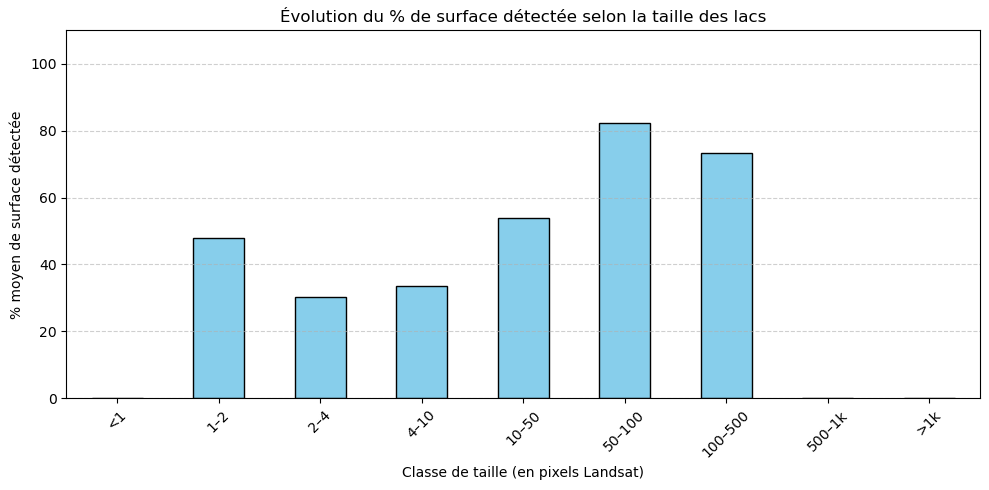

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Créer une colonne avec le nombre de pixels Landsat


# 2. Définir les bins (classes de taille)


# 3. Appliquer pd.cut pour créer les classes


# 4. Calculer la moyenne du % de surface détectée par classe
bin_means = df_surface_ratio.groupby('pixel_bin')['surface_covered_ratio'].mean()

# 5. Tracer l’évolution du % de surface détectée
plt.figure(figsize=(10, 5))
bin_means.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Classe de taille (en pixels Landsat)')
plt.ylabel('% moyen de surface détectée')
plt.title('Évolution du % de surface détectée selon la taille des lacs')
plt.xticks(rotation=45)
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


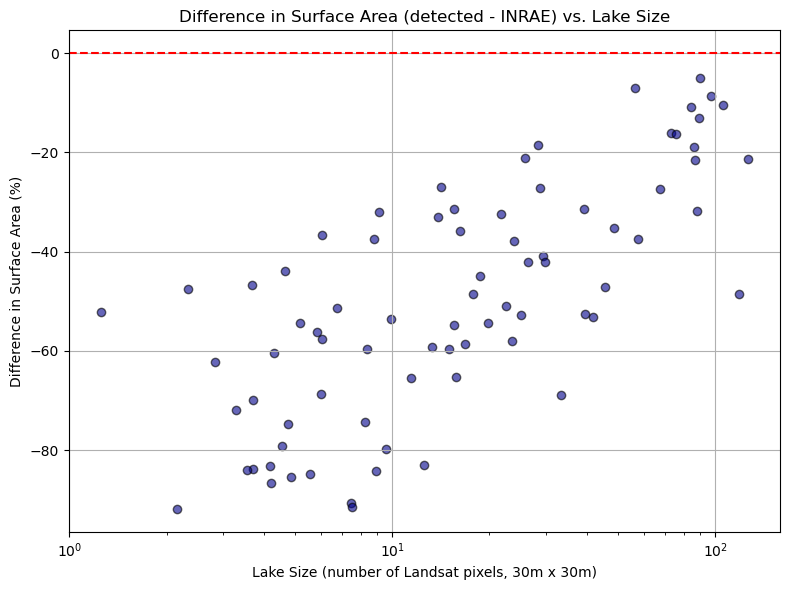

In [115]:

# Conversion des surfaces - ici pas besoin de convertir km² en m², tes surfaces sont déjà en m²
df_surface_ratio['area_m2_classif'] = df_surface_ratio['area_detected_lake_m²']  # surface détectée
df_surface_ratio['area_m2_inrae'] = df_surface_ratio['area_inrae']  # surface INRAE

# Calcul de la différence en m²
df_surface_ratio['surface_diff_m2'] = df_surface_ratio['area_m2_classif'] - df_surface_ratio['area_m2_inrae']

# Taille en pixels Landsat (900 m² par pixel)
df_surface_ratio['area_pixels_landsat'] = df_surface_ratio['area_m2_inrae'] / 900

# Différence en % relative à INRAE
df_surface_ratio['surface_diff_percent'] = (df_surface_ratio['surface_diff_m2'] / df_surface_ratio['area_m2_inrae']) * 100

# Suppression des lignes avec NaN pour éviter les erreurs de plot
df_plot = df_surface_ratio.dropna(subset=['area_pixels_landsat', 'surface_diff_percent'])

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(df_plot['area_pixels_landsat'], df_plot['surface_diff_percent'], alpha=0.6, color='darkblue', edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.title("Difference in Surface Area (detected - INRAE) vs. Lake Size")
plt.xlabel("Lake Size (number of Landsat pixels, 30m x 30m)")
plt.ylabel("Difference in Surface Area (%)")
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
#plt.savefig("C:/Users/ronir/Desktop/Stage_Carrtel_2025/Resultats/validation_lake_classif/Bilan_validation_clean/Difference_in_Surface_Area_(detected_INRAE)_vs_Lake_Size")
plt.show()

Valeur abérante à cause de mismatch id, 

 ## Comparison of surface detected/not detetected

In [116]:
df_surface_ratio

,lake_id,area_detected_lake_m²,area_inrae,surface_covered_ratio,real_surface_covered_ratio_clipped,landsat_pixels,pixel_bin,area_m2_classif,area_m2_inrae,surface_diff_m2,area_pixels_landsat,surface_diff_percent
0,13.0,507.001860,3780.062078,13.412527,13.412527,4.200069,4–10,507.001860,3780.062078,-3273.060218,4.200069,-86.587473
1,14.0,1078.087849,4275.174484,25.217400,25.217400,4.750194,4–10,1078.087849,4275.174484,-3197.086636,4.750194,-74.782600
2,17.0,8872.841283,21113.624797,42.024244,42.024244,23.459583,10–50,8872.841283,21113.624797,-12240.783514,23.459583,-57.975756
3,19.0,62592.812662,77285.598031,80.988974,80.988974,85.872887,50–100,62592.812662,77285.598031,-14692.785369,85.872887,-19.011026
4,21.0,4136.809516,8925.679161,46.347280,46.347279,9.917421,4–10,4136.809516,8925.679161,-4788.869645,9.917421,-53.652720
...,...,...,...,...,...,...,...,...,...,...,...,...
73,1399.0,15468.462201,26693.767280,57.947842,57.947842,29.659741,10–50,15468.462201,26693.767280,-11225.305079,29.659741,-42.052158
74,1611.0,156.776521,1938.237046,8.088614,8.088614,2.153597,2–4,156.776521,1938.237046,-1781.460524,2.153597,-91.911386
75,2057.0,5549.722612,8166.674673,67.955720,67.955719,9.074083,4–10,5549.722612,8166.674673,-2616.952061,9.074083,-32.044280
76,2253.0,540.133464,1128.012572,47.883639,47.883639,1.253347,1–2,540.133464,1128.012572,-587.879109,1.253347,-52.116361


In [117]:
df_surface_ratio.sort_values(by='surface_diff_percent')

,lake_id,area_detected_lake_m²,area_inrae,surface_covered_ratio,real_surface_covered_ratio_clipped,landsat_pixels,pixel_bin,area_m2_classif,area_m2_inrae,surface_diff_m2,area_pixels_landsat,surface_diff_percent
74,1611.0,156.776521,1938.237046,8.088614,8.088614,2.153597,2–4,156.776521,1938.237046,-1781.460524,2.153597,-91.911386
71,887.0,575.989812,6733.362031,8.554268,8.554268,7.481513,4–10,575.989812,6733.362031,-6157.372219,7.481513,-91.445732
57,343.0,630.203200,6729.216408,9.365180,9.365180,7.476907,4–10,630.203200,6729.216408,-6099.013208,7.476907,-90.634820
0,13.0,507.001860,3780.062078,13.412527,13.412527,4.200069,4–10,507.001860,3780.062078,-3273.060218,4.200069,-86.587473
68,378.0,633.776857,4359.523832,14.537754,14.537754,4.843915,4–10,633.776857,4359.523832,-3725.746975,4.843915,-85.462246
...,...,...,...,...,...,...,...,...,...,...,...,...
5,30.0,67698.689384,75935.942083,89.152366,89.152366,84.373269,50–100,67698.689384,75935.942083,-8237.252699,84.373269,-10.847634
65,367.0,84995.268306,94886.780436,89.575458,89.575457,105.429756,100–500,84995.268306,94886.780436,-9891.512130,105.429756,-10.424542
36,221.0,79630.957788,87077.219631,91.448668,91.448668,96.752466,50–100,79630.957788,87077.219631,-7446.261843,96.752466,-8.551332
18,157.0,47341.764817,50945.033729,92.927144,92.927144,56.605593,50–100,47341.764817,50945.033729,-3603.268911,56.605593,-7.072856


C:\Users\ronir\AppData\Local\Temp\ipykernel_29432\3418543513.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_surface_ratio.groupby('pixel_bin', observed=True).apply(compute_group_stats).reset_index()


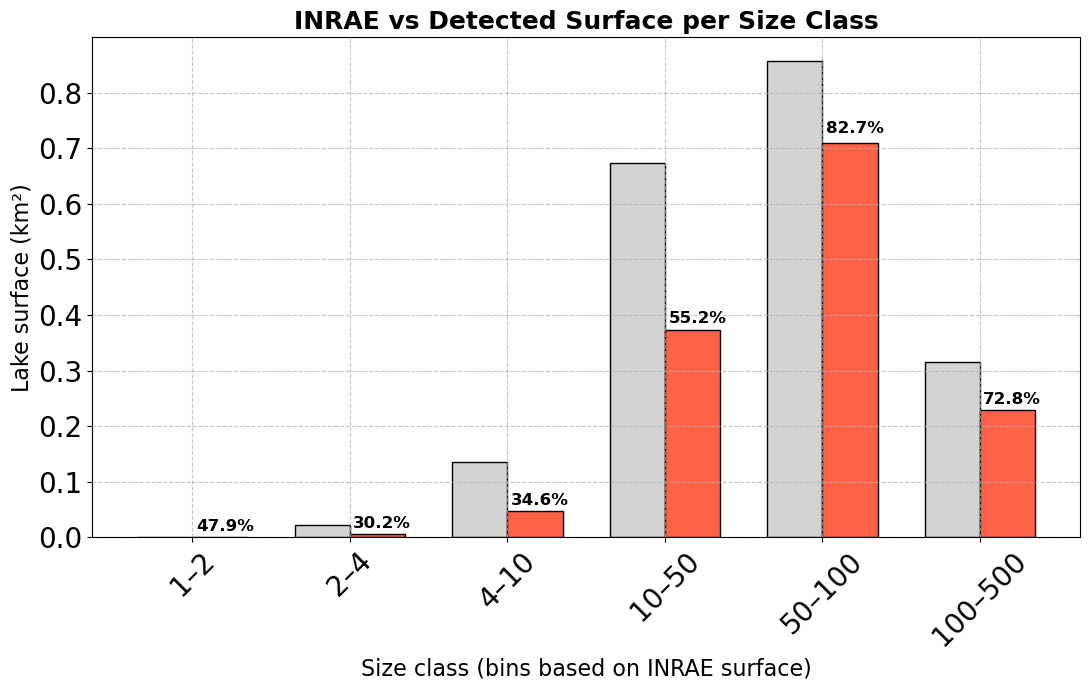

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# --- 1. Calcul du pourcentage détecté par lac ---
df_surface_ratio['surface_covered_ratio'] = (
    df_surface_ratio['area_detected_lake_m²'] / df_surface_ratio['area_inrae']
) * 100

# --- 2. Agrégation par classe ---
def compute_group_stats(x):
    sum_area_inrae = x['area_inrae'].sum()
    weighted_ratio = (
        (x['surface_covered_ratio'] * x['area_inrae']).sum() / sum_area_inrae
        if sum_area_inrae > 0 else np.nan
    )
    return pd.Series({
        'sum_area_inrae': sum_area_inrae,
        'sum_area_detected': x['area_detected_lake_m²'].sum(),
        'weighted_avg_surface_covered_ratio': weighted_ratio
    })

grouped = df_surface_ratio.groupby('pixel_bin', observed=True).apply(compute_group_stats).reset_index()

# --- 3. Conversion en km² ---
grouped['sum_area_inrae'] /= 1e6
grouped['sum_area_detected'] /= 1e6

# --- 4. Totaux globaux ---
total_inrae = grouped['sum_area_inrae'].sum()
total_detected = grouped['sum_area_detected'].sum()
global_ratio = (total_detected / total_inrae) * 100

# --- 5. Graphique ---
fig, ax = plt.subplots(figsize=(11, 7))
x = np.arange(len(grouped['pixel_bin']))
width = 0.35

# Couleurs
color_inrae = '#e06666'
color_detected = '#6fa8dc'

# Barres
bar_inrae = ax.bar(x - width/2, grouped['sum_area_inrae'], width=width, color='lightgray',  edgecolor='black')
bar_detected = ax.bar(x + width/2, grouped['sum_area_detected'], width=width, color='tomato', edgecolor='black')

# Axes
ax.set_xticks(x)
ax.set_xticklabels(grouped['pixel_bin'], rotation=45, fontsize=14)  # taille plus grande pour ticks X
ax.set_ylabel('Lake surface (km²)', fontsize=16)  # taille plus grande label Y
ax.set_xlabel('Size class (bins based on INRAE surface)', fontsize=16)  # taille plus grande label X
ax.set_title('INRAE vs Detected Surface per Size Class', fontsize=18, fontweight='bold')  # taille plus grande titre
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Taille des ticks Y
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)


# Annotations des % au-dessus des barres détectées
for i, (x_pos, det, pct) in enumerate(zip(x, grouped['sum_area_detected'], grouped['weighted_avg_surface_covered_ratio'])):
    if pd.notna(pct) and np.isfinite(pct):
        y_pos = det + max(det * 0.02, 0.005)
        ax.text(x_pos+0.03 + width/2, y_pos, f'{pct:.1f}%', ha='center', va='bottom',
                fontsize=12, color='black', fontweight='bold')

# --- Légende principale ---
legend_elements = [
    Patch(facecolor='lightgray', label='Lake in INRAE Inventory'),
    Patch(facecolor='tomato', label='Lake detected'),
    Line2D([-10], [0], linestyle='None', color='black', label=f'Detected surface ratio per class (%): {82.7:.1f}%')
]

#ax.legend(handles=legend_elements, loc='center left', fontsize=14)

# --- Encadré haut gauche : Totaux globaux ---
text_box = (
    f"Total INRAE surface: {total_inrae:.2f} km²\n"
    f"Total detected surface: {total_detected:.2f} km²\n"
    f"Average detected surface ratio: {global_ratio:.1f} %"
)
# ax.text(0.02, 0.95, text_box, transform=ax.transAxes,
#         fontsize=14, 
#         bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.95),
#         verticalalignment='top')

plt.tight_layout()
plt.savefig('C:/Users/ronir/Desktop/Stage_Carrtel_2025/Figure_def/INRAE_vs_classif')
plt.show()


In [189]:
# Filtrer les lacs détectés
detected_lakes = df_surface_ratio[df_surface_ratio['area_detected_lake_m²'] > 0]

# Compter le nombre de lacs détectés par bin
detected_per_bin = detected_lakes.groupby('pixel_bin')['lake_id'].count().reset_index(name='n_detected_lakes')

print(detected_per_bin)

  pixel_bin  n_detected_lakes
0        <1                 0
1       1–2                 1
2       2–4                 8
3      4–10                23
4     10–50                31
5    50–100                12
6   100–500                 3
7    500–1k                 0
8       >1k                 0


C:\Users\ronir\AppData\Local\Temp\ipykernel_29972\3526403912.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  detected_per_bin = detected_lakes.groupby('pixel_bin')['lake_id'].count().reset_index(name='n_detected_lakes')


----------------------------------------------

----------------------------------------------

# Test for 2000